In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
file = "/content/DAYTON_hourly.csv"
df = pd.read_csv(file)

df.columns = ["Datetime", "Load"]
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime").sort_index()

In [3]:
min_load = df["Load"].min()
max_load = df["Load"].max()
min_time = df["Load"].idxmin()
max_time = df["Load"].idxmax()

print("Minimum Load :", min_load, "at", min_time)
print("Maximum Load :", max_load, "at", max_time)

Minimum Load : 982.0 at 2008-09-14 18:00:00
Maximum Load : 3746.0 at 2007-08-08 15:00:00


In [4]:
df["hour"] = df.index.hour
df["dow"] = df.index.dayofweek
df["month"] = df.index.month
df["lag_1"] = df["Load"].shift(1)
df["lag_24"] = df["Load"].shift(24)
df["rolling_24"] = df["Load"].rolling(24).mean()
df = df.dropna()

X = df[["hour","dow","month","lag_1","lag_24","rolling_24"]]
y = df["Load"]

In [5]:
split = int(len(df)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [6]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [7]:
print("MAE :", mean_absolute_error(y_test, pred))
print("R²  :", r2_score(y_test, pred))

MAE : 59.43444729055765
R²  : 0.9589646246685922


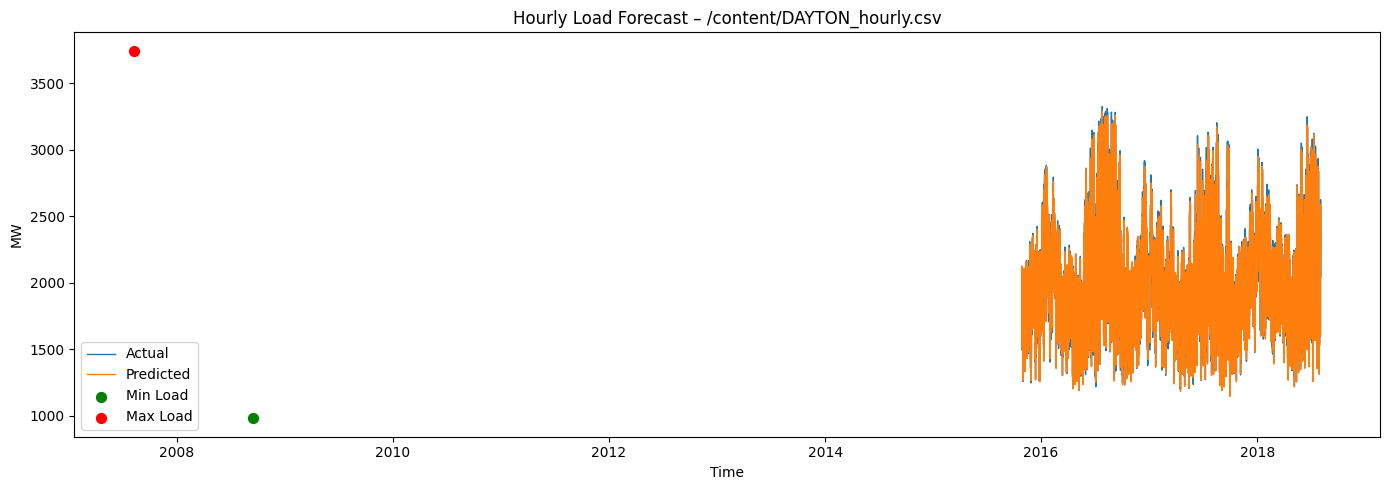

In [8]:
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=1)
plt.plot(y_test.index, pred, label="Predicted", linewidth=1)
plt.scatter(min_time, min_load, color='green', s=50, label='Min Load')
plt.scatter(max_time, max_load, color='red', s=50, label='Max Load')
plt.title(f"Hourly Load Forecast – {file}")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
fig = px.line(
    x=y_test.index,
    y=[y_test.values, pred],
    labels={'x':"Time","value":"Load (MW)"},
    title=f"Interactive Forecast – {file}"
)
fig.data[0].name = "Actual"
fig.data[1].name = "Predicted"


fig.add_scatter(x=[min_time], y=[min_load], mode='markers', name='Min Load')
fig.add_scatter(x=[max_time], y=[max_load], mode='markers', name='Max Load')

fig.update_layout(template="plotly_white")
fig.show()

In [10]:
xg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9
)

xg.fit(X_train, y_train)
pred_xg = xg.predict(X_test)

print("\n---------------- XGBOOST RESULTS ----------------")
print("MAE :", mean_absolute_error(y_test, pred_xg))
print("R²  :", r2_score(y_test, pred_xg))



---------------- XGBOOST RESULTS ----------------
MAE : 22.538534427985894
R²  : 0.9930935194516275


In [12]:
last = df.iloc[-1:].copy()

future_pred = {}

for step in [1, 24, 24*7, 24*30]:   # next hour, 1 day, 1 week, 1 month
    temp = last.copy()

    temp["hour"] = (temp["hour"] + step) % 24
    temp["dow"] = (temp["dow"] + (step//24)) % 7
    temp["month"] = temp.index.month[0]

    temp["lag_1"] = df["Load"].iloc[-1]
    temp["lag_24"] = df["Load"].iloc[-24]
    temp["rolling_24"] = df["Load"].tail(24).mean()

    future_pred[step] = float(
        xg.predict(temp[["hour","dow","month","lag_1","lag_24","rolling_24"]])[0]
    )

print("\n---------------- FUTURE FORECAST ----------------")
print("Next Hour  :", round(future_pred[1], 2))
print("Next Day   :", round(future_pred[24],2))
print("Next Week  :", round(future_pred[168],2))
print("Next Month :", round(future_pred[720],2))


---------------- FUTURE FORECAST ----------------
Next Hour  : 1872.12
Next Day   : 1848.34
Next Week  : 1851.99
Next Month : 1867.86
